In [1]:
import numpy as np
import pandas as pd
import json
import tensorflow as tf

import utils

c:\Users\Loren\anaconda\envs\TFM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Importación y transformación de datos
Cargamos 501 imágenes aleatorias del dataset Mapillary

In [2]:
dir_img = "./mapillary_img/validation/images"
dir_lab = "./mapillary_img/validation/labels"

img_dataset = tf.keras.utils.image_dataset_from_directory(dir_img, batch_size=5, labels = None, 
                                        image_size = (526, 957), shuffle = False, seed = 0,
                                        validation_split = 0, interpolation = 'bilinear').map(lambda x : x/255)

lab_dataset = tf.data.Dataset.from_tensor_slices(utils.get_labels(dir_lab, 501)).batch(5)

Found 501 files belonging to 1 classes.


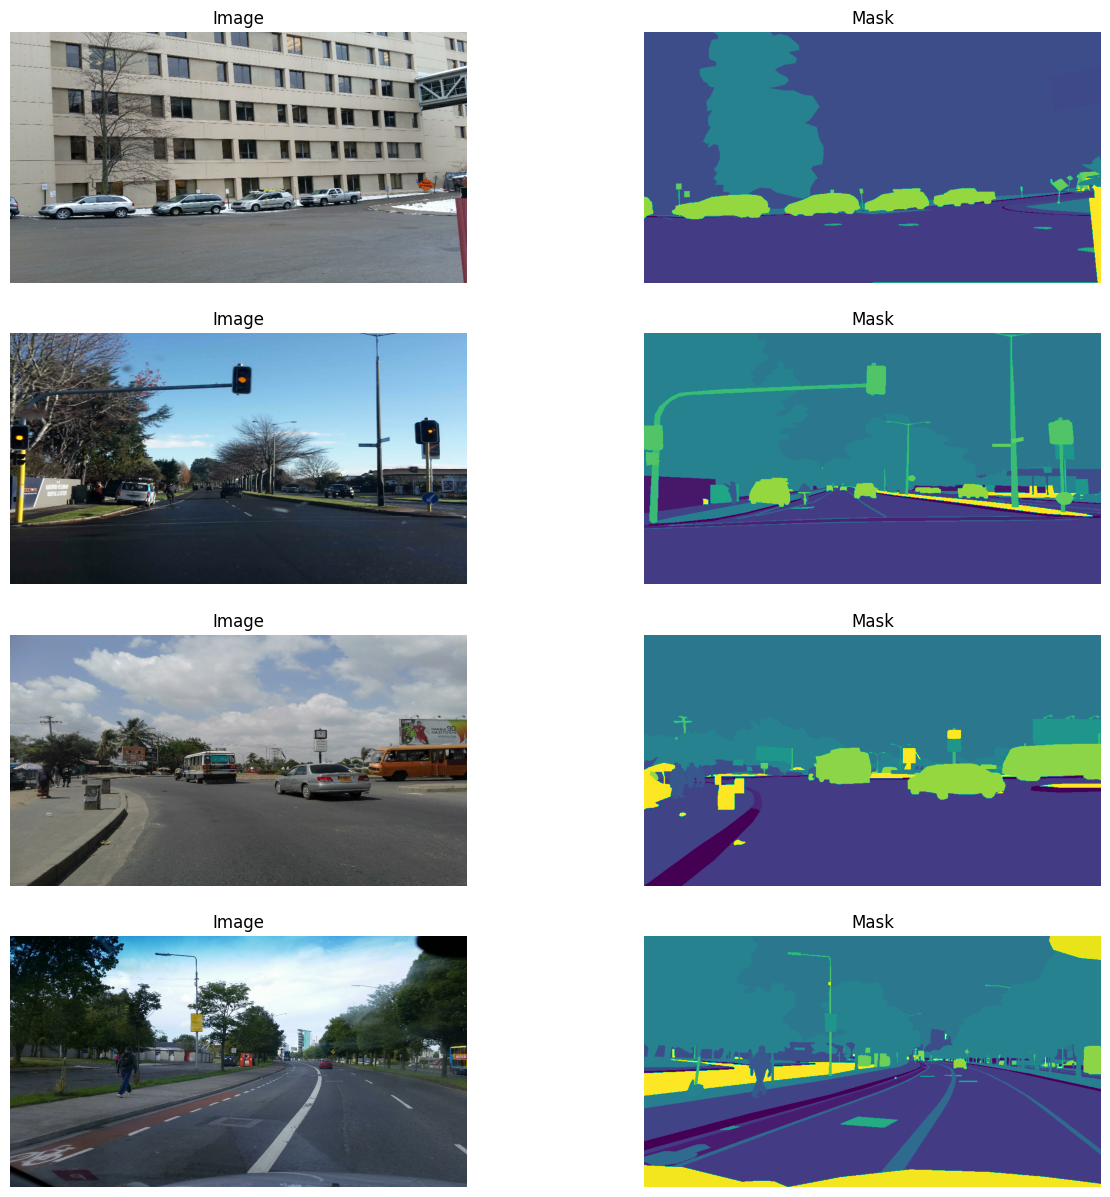

In [3]:
dataset_orig = tf.data.Dataset.zip((img_dataset, lab_dataset))

utils.show_image_and_mask(dataset = dataset_orig)

El dataset Mapillary contiene 66 categorías diferentes, por lo que debemos reducirlas para poder hacer inferencia a través de nuestros modelos que predicen las 20 categorías presentes en el dataset cityscapes. Usamos el mapeo de etiquetas que usan en el paper.

URL: https://www.researchgate.net/publication/338116160_Segmentations-Leak_Membership_Inference_Attacks_and_Defenses_in_Semantic_Image_Segmentation

A continuación aplicamos el mapeo de categorías y normalizamos las imágenes para poder pasarlas por los modelos.

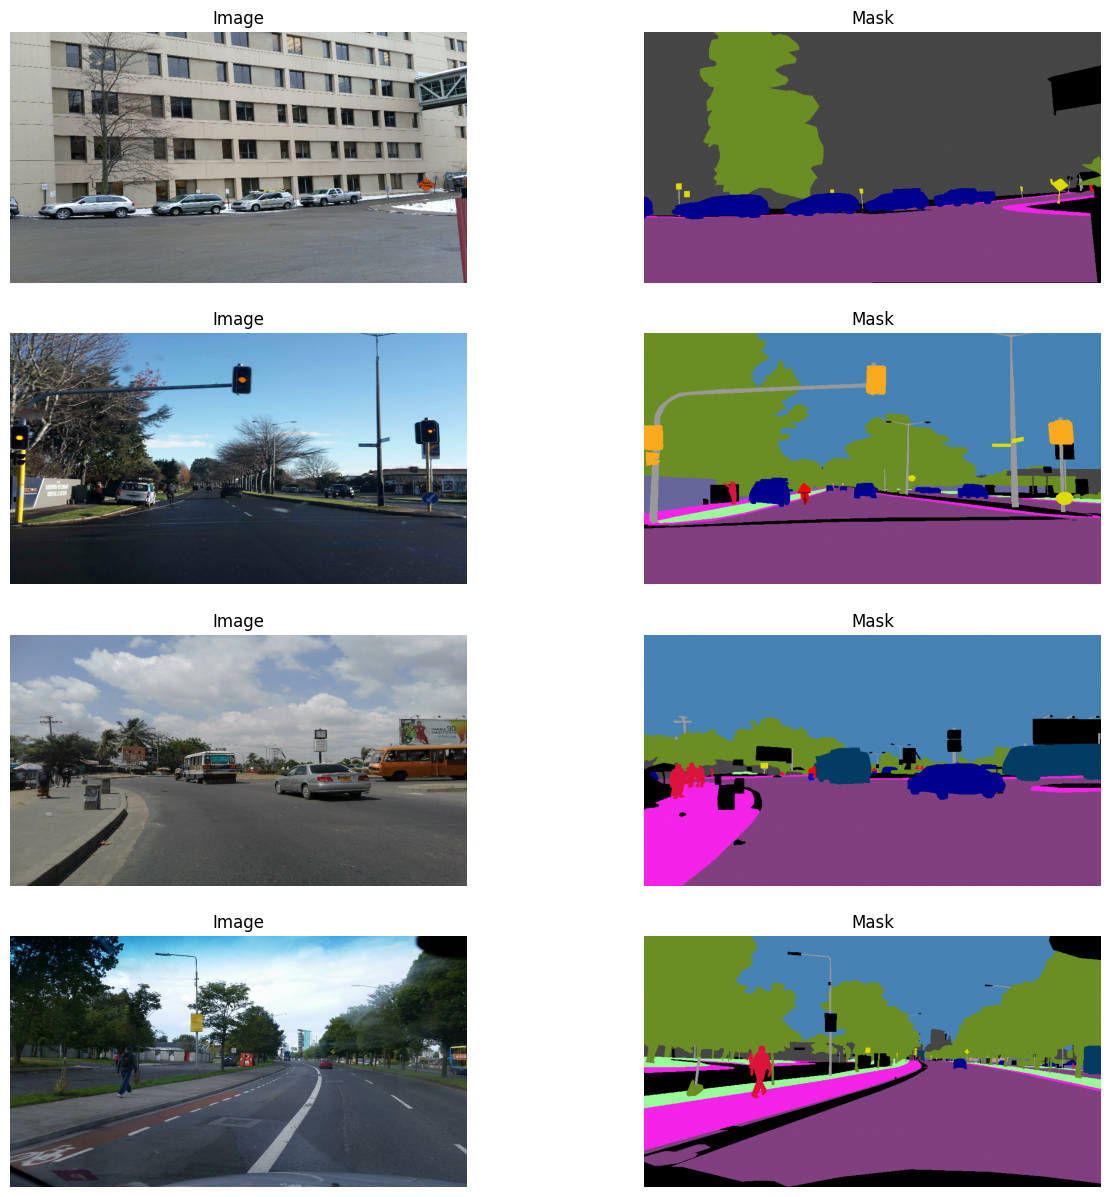

In [4]:
mapeo = json.load(open('mapeo_mapillary.json'))
color_dic = json.load(open('color_dictionary.json'))

img_ds = img_dataset.map(utils.normalize)
lab_ds = lab_dataset.map(lambda x: utils.map_categories(x, mapeo))

ds = tf.data.Dataset.zip((img_dataset, lab_ds))

utils.show_image_and_mask(dataset = ds, color_map = True, dic_colors = color_dic)

Cada color en la máscara de segmentación se corresponde con una categoría del dataset Cityscapes.

In [5]:
cat_cityscapes = json.load(open('cityscapes_categories.json'))
pd.DataFrame(cat_cityscapes.items(), columns = ['id', 'category']).set_index(['id'])

,category
id,
0,road
1,sidewalk
2,building
3,wall
4,fence
5,pole
6,traffic light
7,traffic sign
8,vegetation


## Importación de modelos y resultados
A continuación exponemos los resultados de cada uno de los modelos del TFM
### Modelo preentrenado en Cityscapes

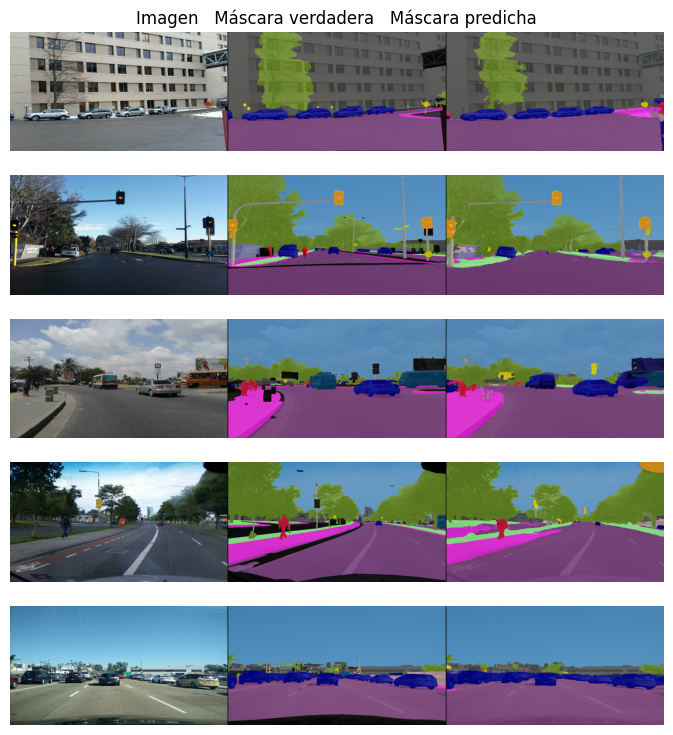

In [6]:
output_cityscapes =np.load('./modelos/cityscapes/results/inferencia_cityscapes.npy')

output_category_cityscapes_ds = utils.post_process_output(output_cityscapes)
results_ds_cityscapes = tf.data.Dataset.zip((lab_ds, output_category_cityscapes_ds))

utils.show_results(img_dataset, lab_ds, output_category_cityscapes_ds, size = (15, 9), alpha = 0.8, file_name = "img_resultados_cityscapes", dic_color = color_dic, save = False)